<a href="https://colab.research.google.com/github/Junior-sls/HeatIndex---Estimativa-Regress-o-Multipla/blob/main/FatoresClimaHeatIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
caminho_dataset1 = '/content/gdrive/My Drive/Colab Notebooks/DATASET_TEMP(1).csv'
df = pd.read_csv(caminho_dataset1, delimiter=';', decimal=',')

mask_24h = df['Hora'] == '24:00:00'
df.loc[mask_24h, 'Hora'] = '00:00:00'
df['Data_dt'] = pd.to_datetime(df['Data'], dayfirst=True)
df.loc[mask_24h, 'Data_dt'] = df.loc[mask_24h, 'Data_dt'] + pd.Timedelta(days=1)
df['Data_str'] = df['Data_dt'].dt.strftime('%d/%m/%Y')

df['DataHora'] = pd.to_datetime(df['Data_str'] + ' ' + df['Hora'], format='%d/%m/%Y %H:%M', errors='coerce')
df.dropna(subset=['DataHora'], inplace=True)
df.set_index('DataHora', inplace=True)
df.sort_index(inplace=True)

In [ ]:
df['Temp_F'] = df['Temperatura'] * 9/5 + 32
T = df['Temp_F']
RH = df['Umidade']
HI_F = (-42.379 + 2.04901523*T + 10.14333127*RH - 0.22475541*T*RH
        - 6.83783e-3*T**2 - 5.481717e-2*RH**2 + 1.22874e-3*T**2*RH
        + 8.5282e-4*T*RH**2 - 1.99e-6*T**2*RH**2)
HI_F = np.where(T < 80, T, HI_F)
df['Heat_Index'] = (HI_F - 32) * 5/9

In [ ]:
df.dropna(subset=['Temperatura', 'Umidade', 'Velocidade_Vento', 'Pressao', 'Radiacao_Solar'], inplace=True)
X = df[['Temperatura', 'Umidade', 'Velocidade_Vento', 'Pressao', 'Radiacao_Solar']]
y = df['Heat_Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
df['HI_Estimado'] = model.predict(X)
df['Trimestre'] = df.index.to_period('Q')

print("\nResumo Estatístico Trimestral:")
print(df.groupby('Trimestre')[['Heat_Index', 'HI_Estimado']].agg(['mean', 'std', 'min', 'max']))

def calcular_rmse(grupo):
    return np.sqrt(mean_squared_error(grupo['Heat_Index'], grupo['HI_Estimado']))

rmse_trimestral = df.groupby('Trimestre').apply(calcular_rmse, include_groups=False)
print("\nRMSE por Trimestre:")
print(rmse_trimestral)


Resumo Estatístico Trimestral:
          Heat_Index                            HI_Estimado            \
                mean       std   min        max        mean       std   
Trimestre                                                               
2024Q1     24.325884  2.841706  20.5  31.486019   24.816434  2.696558   
2024Q2     23.662492  4.025677  15.5  37.712252   23.979991  4.261966   
2024Q3     19.320702  3.228230   9.3  36.073790   19.141950  3.848150   
2024Q4     23.994500  3.563241  16.8  38.712328   24.236952  3.518082   
2025Q1     28.430478  5.048004  19.6  43.535789   27.998294  4.006710   

                                 
                 min        max  
Trimestre                        
2024Q1     20.519759  31.439242  
2024Q2     14.219452  39.929543  
2024Q3      6.810125  40.804050  
2024Q4     15.870116  38.466994  
2025Q1     19.096772  46.354220  

RMSE por Trimestre:
Trimestre
2024Q1    0.798107
2024Q2    0.828772
2024Q3    0.704268
2024Q4    0.711739
2025

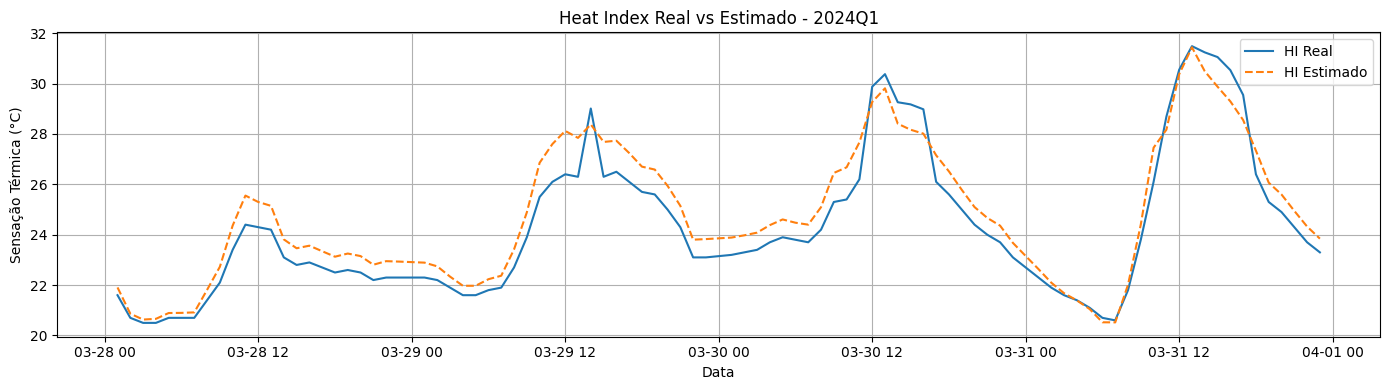

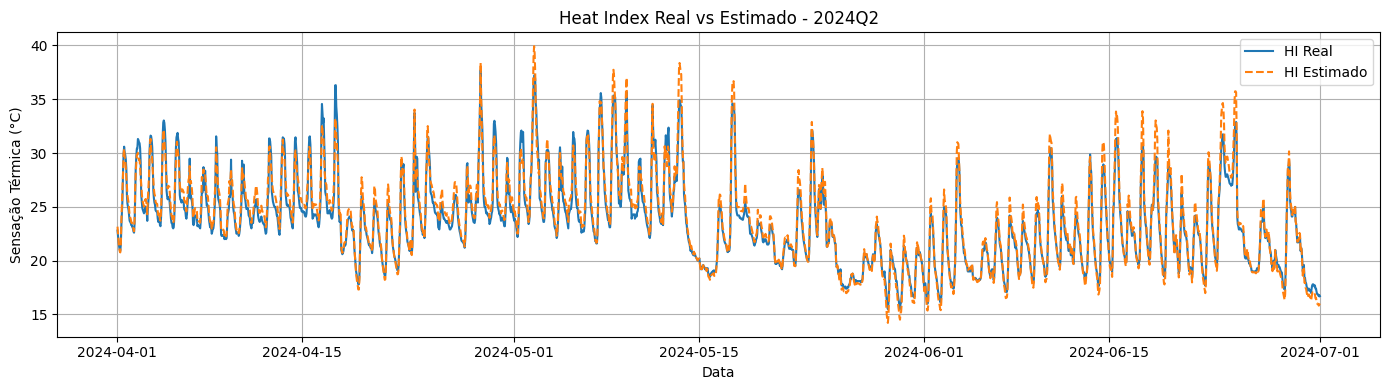

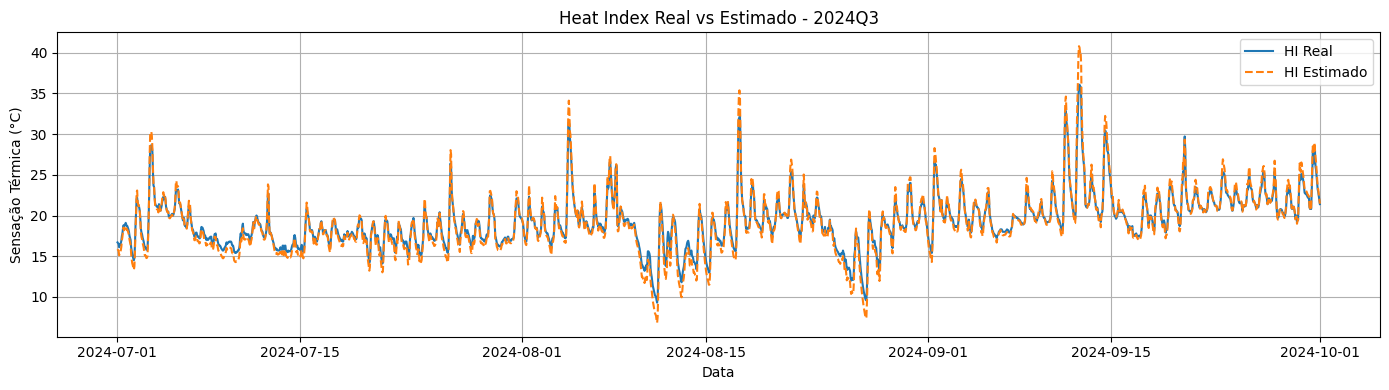

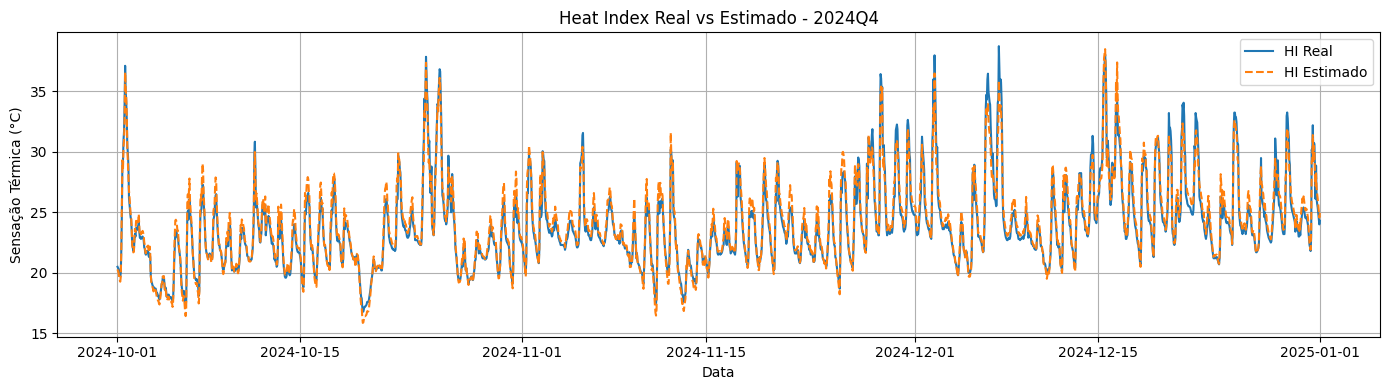

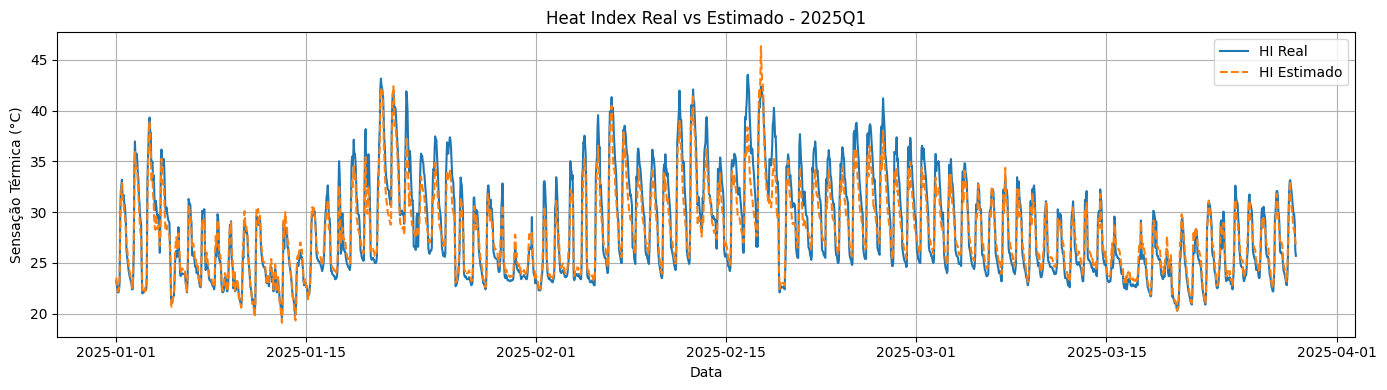


Modelos por Trimestre:

Trimestre: 2024Q1
R²: 0.9459 | RMSE: 0.5566 °C
Coeficientes:
  Temperatura      = 1.0697
  Umidade          = 0.0067
  Velocidade_Vento = 0.4481
  Pressao          = -0.0911
  Radiacao_Solar   = 0.0021

Trimestre: 2024Q2
R²: 0.9725 | RMSE: 0.6175 °C
Coeficientes:
  Temperatura      = 1.0969
  Umidade          = 0.0165
  Velocidade_Vento = 0.1448
  Pressao          = -0.0227
  Radiacao_Solar   = 0.0016

Trimestre: 2024Q3
R²: 0.9976 | RMSE: 0.1590 °C
Coeficientes:
  Temperatura      = 0.9984
  Umidade          = 0.0019
  Velocidade_Vento = 0.0059
  Pressao          = -0.0018
  Radiacao_Solar   = 0.0002

Trimestre: 2024Q4
R²: 0.9673 | RMSE: 0.6555 °C
Coeficientes:
  Temperatura      = 1.1831
  Umidade          = 0.0030
  Velocidade_Vento = -0.1932
  Pressao          = -0.0099
  Radiacao_Solar   = 0.0010

Trimestre: 2025Q1
R²: 0.9455 | RMSE: 1.1198 °C
Coeficientes:
  Temperatura      = 1.6912
  Umidade          = 0.0709
  Velocidade_Vento = 0.3309
  Pressao        

In [ ]:
for trimestre, grupo in df.groupby('Trimestre'):
    plt.figure(figsize=(14, 4))
    plt.plot(grupo.index, grupo['Heat_Index'], label='HI Real', color='tab:blue')
    plt.plot(grupo.index, grupo['HI_Estimado'], label='HI Estimado', linestyle='--', color='tab:orange')
    plt.title(f'Heat Index Real vs Estimado - {trimestre}')
    plt.xlabel('Data')
    plt.ylabel('Sensação Térmica (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\nModelos por Trimestre:")
for trimestre, grupo in df.groupby('Trimestre'):
    X_tri = grupo[['Temperatura', 'Umidade', 'Velocidade_Vento', 'Pressao', 'Radiacao_Solar']]
    y_tri = grupo['Heat_Index']
    X_train, X_test, y_train, y_test = train_test_split(X_tri, y_tri, test_size=0.2, random_state=42)
    model_tri = LinearRegression().fit(X_train, y_train)
    y_pred = model_tri.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    coef = model_tri.coef_
    print(f"\nTrimestre: {trimestre}")
    print(f"R²: {r2:.4f} | RMSE: {rmse:.4f} °C")
    print(f"Coeficientes:")
    print(f"  Temperatura      = {coef[0]:.4f}")
    print(f"  Umidade          = {coef[1]:.4f}")
    print(f"  Velocidade_Vento = {coef[2]:.4f}")
    print(f"  Pressao          = {coef[3]:.4f}")
    print(f"  Radiacao_Solar   = {coef[4]:.4f}")


Matriz de Correlação das Features:
                  Temperatura   Umidade  Velocidade_Vento   Pressao  \
Temperatura          1.000000 -0.684696          0.444021 -0.624413   
Umidade             -0.684696  1.000000         -0.527704  0.242650   
Velocidade_Vento     0.444021 -0.527704          1.000000 -0.085551   
Pressao             -0.624413  0.242650         -0.085551  1.000000   
Radiacao_Solar       0.462222 -0.496086          0.474603 -0.064901   

                  Radiacao_Solar  
Temperatura             0.462222  
Umidade                -0.496086  
Velocidade_Vento        0.474603  
Pressao                -0.064901  
Radiacao_Solar          1.000000  


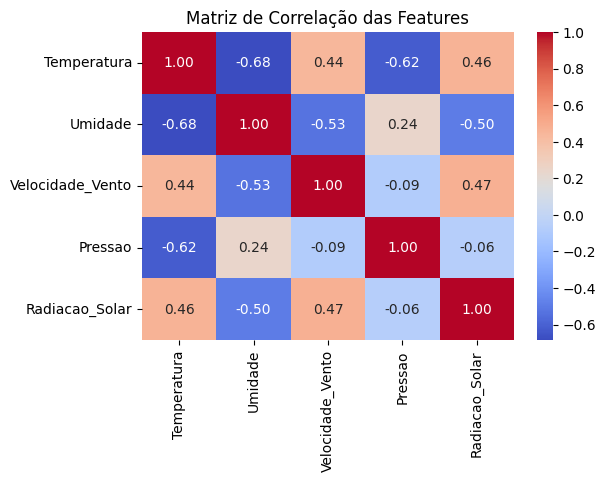

In [ ]:
matriz_correlacao = X.corr()
print("\nMatriz de Correlação das Features:")
print(matriz_correlacao)

plt.figure(figsize=(6, 4))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação das Features")
plt.show()

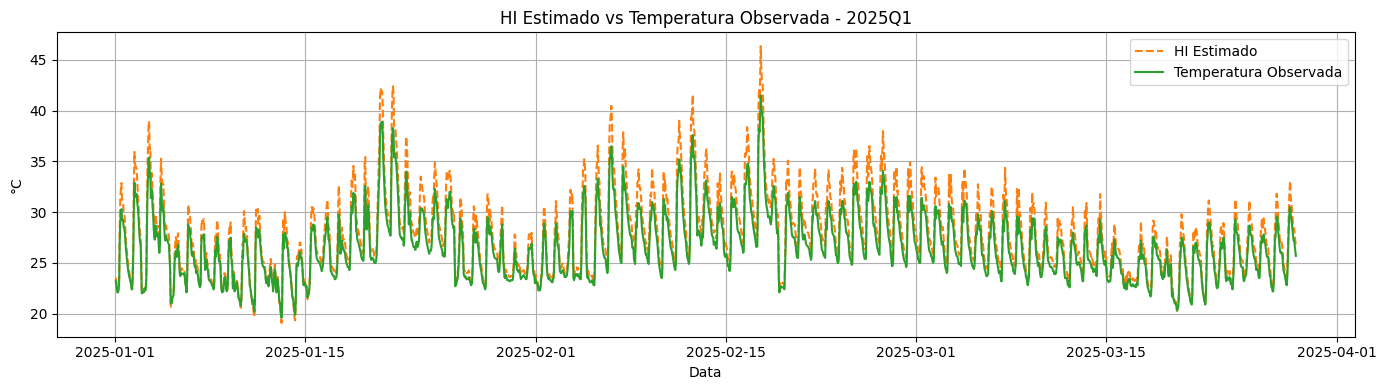

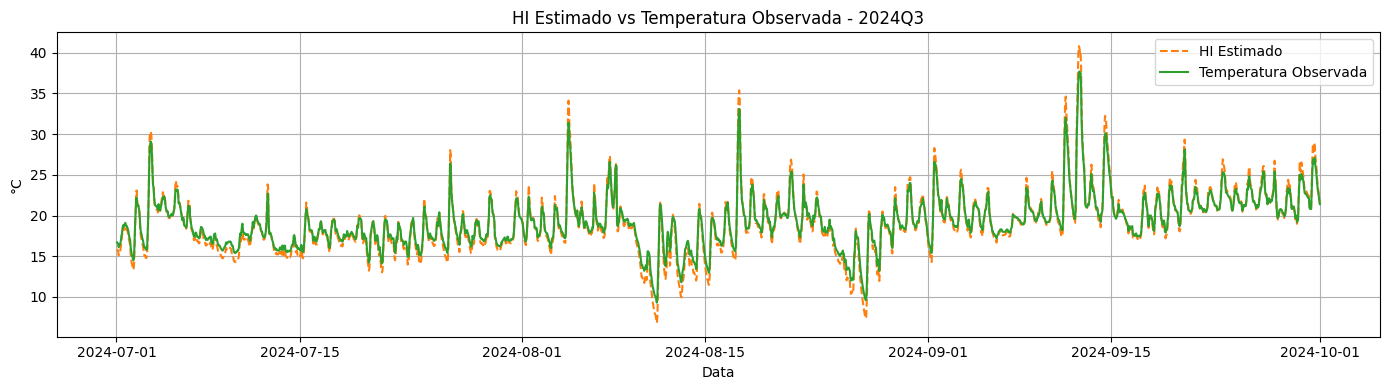

In [ ]:
ultimo_trimestre = df['Trimestre'].max()
grupo_ultimo = df[df['Trimestre'] == ultimo_trimestre]

plt.figure(figsize=(14, 4))
plt.plot(grupo_ultimo.index, grupo_ultimo['HI_Estimado'], label='HI Estimado', linestyle='--', color='tab:orange')
plt.plot(grupo_ultimo.index, grupo_ultimo['Temperatura'], label='Temperatura Observada', color='tab:green')
plt.title(f'HI Estimado vs Temperatura Observada - {ultimo_trimestre}')
plt.xlabel('Data')
plt.ylabel('°C')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

trimestre_2024Q3 = '2024Q3'
grupo_q3_2024 = df[df['Trimestre'] == trimestre_2024Q3]

if not grupo_q3_2024.empty:
    plt.figure(figsize=(14, 4))
    plt.plot(grupo_q3_2024.index, grupo_q3_2024['HI_Estimado'], label='HI Estimado', linestyle='--', color='tab:orange')
    plt.plot(grupo_q3_2024.index, grupo_q3_2024['Temperatura'], label='Temperatura Observada', color='tab:green')
    plt.title(f'HI Estimado vs Temperatura Observada - {trimestre_2024Q3}')
    plt.xlabel('Data')
    plt.ylabel('°C')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

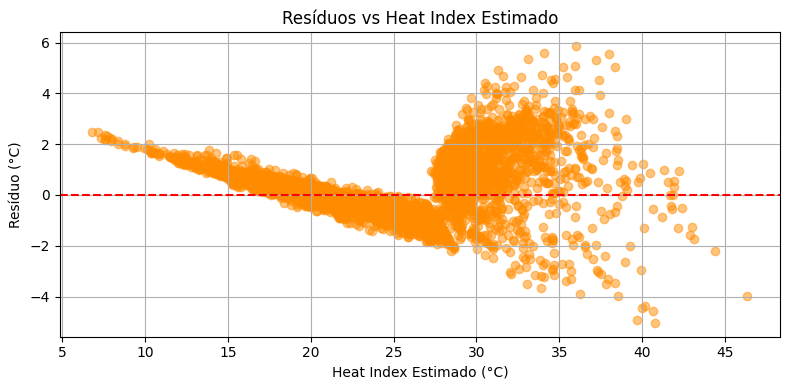


Média dos Resíduos: 0.0025 °C
Desvio Padrão dos Resíduos: 0.9858 °C


In [ ]:
df['Residuos'] = df['Heat_Index'] - df['HI_Estimado']

plt.figure(figsize=(8, 4))
plt.scatter(df['HI_Estimado'], df['Residuos'], alpha=0.5, color='darkorange')
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Heat Index Estimado')
plt.xlabel('Heat Index Estimado (°C)')
plt.ylabel('Resíduo (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

media_residuos = df['Residuos'].mean()
std_residuos = df['Residuos'].std()
print(f"\nMédia dos Resíduos: {media_residuos:.4f} °C")
print(f"Desvio Padrão dos Resíduos: {std_residuos:.4f} °C")